# Test 4.2
### Fit pixelated lens potential perturbations on a smooth SIE model and an elliptical Sérsic source.
The potential perturbation here is a single localised substructure on the Einstein ring.

__last update__: 23/07/21

In [1]:
# Basic imports
from time import time
import numpy as np
from scipy.optimize import minimize, Bounds, LinearConstraint
import matplotlib.pyplot as plt
from copy import deepcopy
import corner
import powerbox as pbox
%matplotlib inline
plt.rc('image', interpolation='none')

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# JAX-ified lenstronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer
from jaxtronomy.Inference.sampling import Sampler
from jaxtronomy.Util import image_util
from jaxtronomy.Util.jax_util import WaveletTransform

# Universal font size
FS = 18

### Data grids (image plane and source plane)
For simplicity at first, assume both the smooth image plane and the source plane share the same pixelization.
Take the pixelated potential perturbations to live on a lower resolution grid (quarter-size).

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = [x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]]

# Lower resolution interpolation grid
npix_lowres = npix // 4
x_coords_lowres = np.linspace(extent[0], extent[1], npix_lowres)
y_coords_lowres = np.linspace(extent[2], extent[3], npix_lowres)
x_grid_lowres, y_grid_lowres = np.meshgrid(x_coords_lowres, y_coords_lowres)

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
                        'center_x': 0.4, 'center_y': 0.15}]

### Lens models (large-scale SIE + an GRF perturbations)

/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/powerbox/dft.py:212: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


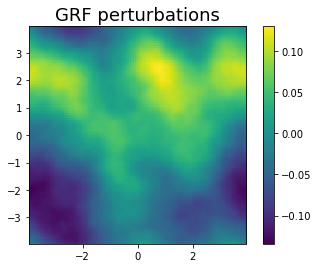

In [4]:
# Potential perturbation as a GRF with power spectrum P(k)=Ak^beta
logA = -4
beta = -5
box_length = 2 * np.pi * npix * pix_scl
pb = pbox.PowerBox(N=npix, dim=2, pk=(lambda k: 10**logA * k**beta), boxlength=box_length, seed=42)
psi_pert_highres = pb.delta_x()

plt.title("GRF perturbations", fontsize=FS)
plt.imshow(psi_pert_highres, origin='lower', extent=extent)
plt.colorbar()
plt.show()

In [5]:
# True lens mass model
true_lens_mass_model_list = ['SIE', 'PIXELATED']
true_lens_mass_model = LensModel(true_lens_mass_model_list)
kwargs_true_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                         {'x_coords': x_coords, 'y_coords': x_coords, 'psi_grid': psi_pert_highres.T}]

# Hybrid lens mass model
hybrid_lens_mass_model_list = ['SIE', 'PIXELATED']
hybrid_lens_mass_model = LensModel(hybrid_lens_mass_model_list)

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

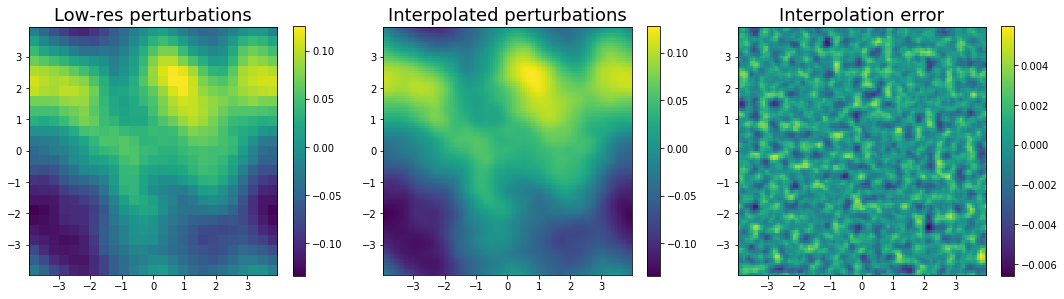

In [6]:
# Extract the true perturbation potential on original and low-res grids
psi_grid_true = true_lens_mass_model.potential(x_grid, y_grid, kwargs_true_lens_mass, k=1)
psi_grid_true_lowres = true_lens_mass_model.potential(x_grid_lowres, y_grid_lowres, kwargs_true_lens_mass, k=1)

# Set the hybrid lens mass model parameters
kwargs_hybrid_lens_mass = [kwargs_true_lens_mass[0],
                           {'x_coords': x_coords_lowres, 
                            'y_coords': y_coords_lowres, 
                            'psi_grid': psi_grid_true_lowres.T}]  # Transpose so that image_model works properly

# Test interpolating the low-res hybrid model to the original grid
psi_grid_interp = hybrid_lens_mass_model.potential(x_grid, y_grid, kwargs_hybrid_lens_mass, k=1)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
img1 = axes[0].imshow(psi_grid_true_lowres, origin='lower', extent=extent)
axes[0].set_title("Low-res perturbations", fontsize=FS)
img2 = axes[1].imshow(psi_grid_interp, origin='lower', extent=extent)
axes[1].set_title("Interpolated perturbations", fontsize=FS)
img3 = axes[2].imshow(psi_grid_true - psi_grid_interp, origin='lower', extent=extent)
axes[2].set_title("Interpolation error", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

### PSF
Ignore the PSF for now.

In [7]:
kwargs_psf = {'psf_type': 'NONE', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Noise

In [8]:
# Noise
exp_time = None
sigma_bkd = 0.01
kwargs_noise = {'background_rms': sigma_bkd,  'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)
noise_hybrid = deepcopy(noise)

### Image model

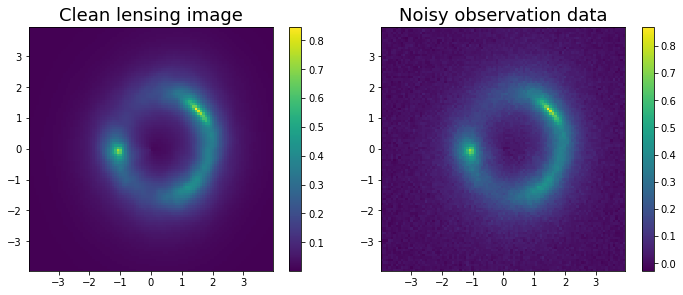

In [9]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
lens_image = LensImage(pixel_grid, psf,
                       noise_class=noise,
                         lens_model_class=true_lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image = lens_image.model(kwargs_lens=kwargs_true_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)


# Observed noisy data
data = lens_image.simulation(kwargs_lens=kwargs_true_lens_mass,
                             kwargs_source=kwargs_source_light,
                             kwargs_lens_light=kwargs_lens_light)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', extent=extent)
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower', extent=extent)
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

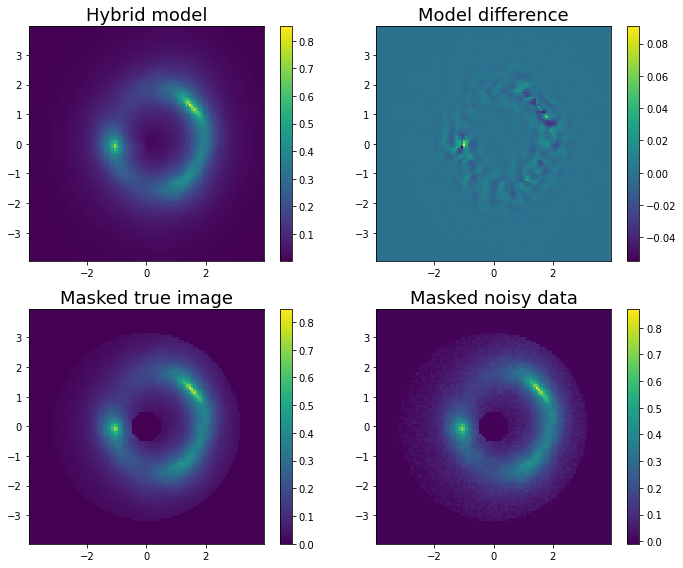

In [10]:
# Hybrid image model for fitting
hybrid_lens_image = LensImage(pixel_grid, psf, noise_class=noise_hybrid,
                                lens_model_class=hybrid_lens_mass_model,
                                source_model_class=source_light_model,
                                lens_light_model_class=lens_light_model,
                                kwargs_numerics=kwargs_numerics)

# Test the hybrid model with the true low-res perturbation grid
hybrid_image = hybrid_lens_image.model(kwargs_lens=kwargs_hybrid_lens_mass,
                                        kwargs_source=kwargs_source_light,
                                        kwargs_lens_light=kwargs_lens_light)

# Generate a mask
rmin = 0.5
rmax = 3.2
# Original grid
radius = np.hypot(x_grid, y_grid)
mask = ((radius >= rmin) & (radius <= rmax)).astype(float)
# Low-res grid
radius_lowres = np.hypot(x_grid_lowres, y_grid_lowres)
mask_lowres = ((radius_lowres >= rmin) & (radius_lowres <= rmax)).astype(float)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
(ax1, ax2), (ax3, ax4) = axes
img1 = ax1.imshow(hybrid_image, origin='lower', extent=extent)
img2 = ax2.imshow(image - hybrid_image, origin='lower', extent=extent)
img3 = ax3.imshow(mask * image, origin='lower', extent=extent)
img4 = ax4.imshow(mask * data, origin='lower', extent=extent)
ax1.set_title("Hybrid model", fontsize=FS)
ax2.set_title("Model difference", fontsize=FS)
ax3.set_title("Masked true image", fontsize=FS)
ax4.set_title("Masked noisy data", fontsize=FS)
for img, ax in zip((img1, img2, img3, img4), np.ravel(axes)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

## Fit the lens potential perturbation as a pixelated grid

### Parameters

Here we select which parameters to optimise, which one are fixed, lower/upper bounds (treated as "uniform" prior).

In [11]:
masked_lower = -10.*np.ones(npix_lowres**2)*mask_lowres.flatten()
masked_upper = +10.*np.ones(npix_lowres**2)*mask_lowres.flatten()

kwargs_model = {
    'lens_model_list': hybrid_lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}
kwargs_init = {
    'kwargs_lens': [{}, {'psi_grid': 1e-8 * np.zeros((npix_lowres, npix_lowres))}],
    'kwargs_source': [{}],
}
kwargs_prior = {
    #'kwargs_lens': [{}, {}],
    #'kwargs_lens': [{}, {'psi_grid': ['uniform', -np.inf, +np.inf]}],
    'kwargs_lens': [{}, {'psi_grid': ['uniform', masked_lower, masked_upper]}],
    'kwargs_source': [{}],
}
kwargs_fixed = {
    'kwargs_lens': [kwargs_hybrid_lens_mass[0], {'x_coords': x_coords_lowres, 'y_coords': y_coords_lowres}],
    'kwargs_source': kwargs_source_light,
}
parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

kwargs_true = {
    'kwargs_lens': kwargs_hybrid_lens_mass, 
    'kwargs_source': kwargs_source_light,
}
p_init = parameters.kwargs2args(kwargs_init)
p_true = parameters.kwargs2args(kwargs_true)
print("truths:", len(p_true), parameters.names[0])

print(parameters.prior_types[0])
#print(parameters.bounds)

truths: 625 dpsi_0
uniform


#### Initial $\delta\psi$ map

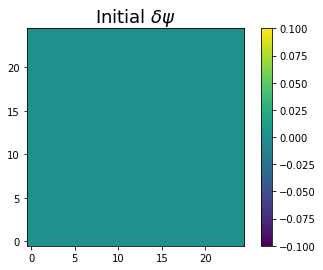

In [12]:
plt.title(r"Initial $\delta\psi$", fontsize=FS)
plt.imshow(p_init.reshape(npix_lowres, npix_lowres), origin='lower')
plt.colorbar()
plt.show()

#### Bounds for $\delta\psi$

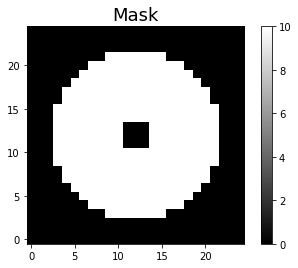

In [13]:
plt.title("Mask", fontsize=FS)
plt.imshow(parameters.bounds[1].reshape(npix_lowres, npix_lowres), origin='lower', cmap='gray')
plt.colorbar()
plt.show()

# Fit the perturbed pixelated potential

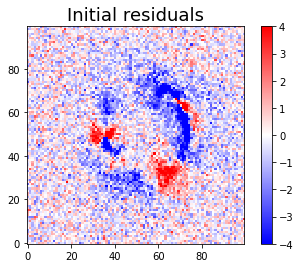

In [14]:
hybrid_image_init = hybrid_lens_image.model(**parameters.args2kwargs(p_init))

plt.title("Initial residuals", fontsize=FS)
plt.imshow((data - hybrid_image_init) / np.sqrt(lens_image.Noise.C_D), origin='lower', cmap='bwr', vmin=-4, vmax=4)
plt.colorbar()
plt.show()

In [27]:
def plot_pixelated_potential_result(optimizer, kwargs_f, shift_potential='min', with_mask=True):
    if optimizer is not None:
        fig, ax = plt.subplots(1, 1)
        ax.plot(range(len(optimizer.loss_history)), optimizer.loss_history)
        ax.set_ylabel("Loss", fontsize=FS)
        ax.set_xlabel("Iteration", fontsize=FS)
        plt.show()
        
    # create the resulting model image
    rec_image = hybrid_lens_image.model(**kwargs_f)
    noise_var = lens_image.Noise.C_D
    alpha_x, alpha_y = hybrid_lens_image.LensModel.alpha(x_grid_lowres, y_grid_lowres, kwargs_final_wt['kwargs_lens'], k=1)
    kappa = hybrid_lens_image.LensModel.kappa(x_grid_lowres, y_grid_lowres, kwargs_final_wt['kwargs_lens'], k=1)

    # Reshape the final psi grid
    psi_grid_rec = kwargs_f['kwargs_lens'][1]['psi_grid'].T
    if shift_potential == 'min':
        min_in_mask = (psi_grid_rec * mask_lowres).min()
        psi_grid_rec = psi_grid_rec - min_in_mask
        print("delta_psi shift by min:", min_in_mask)
    elif shift_potential == 'mean':
        mean_in_mask = (psi_grid_rec * mask_lowres).mean()
        true_mean_in_mask = (psi_grid_true_lowres * mask_lowres).mean()
        psi_grid_rec = psi_grid_rec - mean_in_mask + true_mean_in_mask
        print("delta_psi shift & normalization by mean:", mean_in_mask, true_mean_in_mask)
        
    fig, axes = plt.subplots(3, 3, figsize=(15, 14))
    ax = axes[0, 0]
    img = ax.imshow(data, origin='lower', extent=extent)
    ax.set_title("Data", fontsize=FS)
    fig.colorbar(img, ax=ax)
    ax = axes[0, 1]
    img = ax.imshow(rec_image, origin='lower', extent=extent)
    ax.set_title("Image reconstruction", fontsize=FS)
    fig.colorbar(img, ax=ax)
    ax = axes[0, 2]
    img = ax.imshow((data - rec_image) / jnp.sqrt(noise_var), origin='lower', cmap='RdBu_r', vmin=-4, vmax=4, extent=extent)
    ax.set_title("Normalised residuals", fontsize=FS)
    ax.set_xlabel(f"Chi-sq : {np.mean((data - rec_image)**2 / noise_var):.2f}")
    fig.colorbar(img, ax=ax)

    ax = axes[1, 0]
    psi_grid_true_show = psi_grid_true_lowres
    if with_mask:
        psi_grid_true_show *= mask_lowres
    img = ax.imshow(psi_grid_true_show, origin='lower', extent=extent)
    ax.set_title("True $\delta\psi$", fontsize=FS)
    fig.colorbar(img, ax=ax)
    ax = axes[1, 1]
    psi_grid_rec_show = psi_grid_rec
    if with_mask:
        psi_grid_rec_show *= mask_lowres
    img = ax.imshow(psi_grid_rec_show, origin='lower', extent=extent)
    ax.set_title("Reconstructed $\delta\psi$", fontsize=FS)
    fig.colorbar(img, ax=ax)
    ax = axes[1, 2]
    abs_res_show = (psi_grid_true_lowres - psi_grid_rec)
    if with_mask:
        abs_res_show *= mask_lowres
    vmax = 0.5 * np.max(np.abs(psi_grid_true_lowres))
    img = ax.imshow(abs_res_show, origin='lower', cmap='RdBu_r', vmin=-vmax, vmax=vmax, extent=extent)
    ax.set_title("Absolute residuals", fontsize=FS)
    fig.colorbar(img, ax=ax)

    ax = axes[2, 0]
    ax.set_title(r"$\delta\alpha_x$", fontsize=FS)
    im = ax.imshow(alpha_x.T, origin='lower', cmap='coolwarm', alpha=1, extent=extent)
    fig.colorbar(im, ax=ax)
    ax = axes[2, 1]
    ax.set_title(r"$\delta\alpha_y$", fontsize=FS)
    im = ax.imshow(alpha_y.T, origin='lower', cmap='coolwarm', alpha=1, extent=extent)
    fig.colorbar(im, ax=ax)
    ax = axes[2, 2]
    ax.set_title(r"$\delta\kappa$", fontsize=FS)
    #ax.imshow(hybrid_lens_image.model(**kwargs_final_wt), origin='lower', cmap='gray_r', alpha=0.3, extent=extent)
    im = ax.imshow(kappa.T, origin='lower', cmap='inferno', alpha=1, extent=extent) #, vmin=0)
    fig.colorbar(im, ax=ax)
    
    plt.show()

### Starlet regularization

#### Load pre-estimated potential noise map

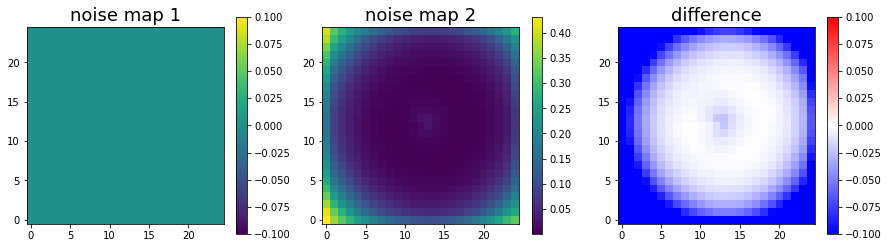

mean level: 0.06255350000000004
mean level within mask: 0.00946830985915493


In [16]:
dpsi_noise_map1 = np.zeros((npix_lowres, npix_lowres)) # np.load(f'data/dpsi_1sigma_bkg{sigma_bkd}_{npix_lowres}px_pixmass.npy')
dpsi_noise_map2 = np.load(f'data/dpsi_1sigma_bkg{sigma_bkd}_{npix_lowres}px_fullmass_fullamp.npy')

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes[0]
ax.set_title("noise map 1", fontsize=FS)
im = ax.imshow(dpsi_noise_map1, origin='lower')
fig.colorbar(im, ax=ax)
ax = axes[1]
ax.set_title("noise map 2", fontsize=FS)
im = ax.imshow(dpsi_noise_map2, origin='lower')
fig.colorbar(im, ax=ax)
ax = axes[2]
ax.set_title("difference", fontsize=FS)
im = ax.imshow(dpsi_noise_map1 - dpsi_noise_map2, origin='lower', cmap='bwr', vmin=-0.1, vmax=0.1)
fig.colorbar(im, ax=ax)
plt.show()

print("mean level:", np.mean(dpsi_noise_map2))
print("mean level within mask:", np.mean(dpsi_noise_map2[mask_lowres == 1.]))

#### Visualise wavelet transforms of true $\delta\psi$

Number of starlet scales: 4
(5, 25, 25)


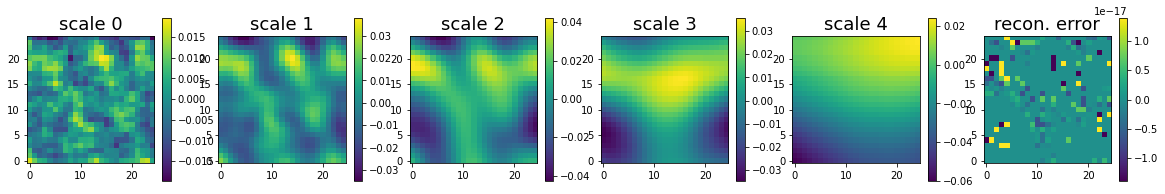

In [17]:
# we consider the maximum number of starlet scales
n_scales = int(np.log2(npix_lowres))
print("Number of starlet scales:", n_scales)
starlet = WaveletTransform(n_scales, wavelet_type='starlet')

# we consider only the first Battle-Lemarie scale
battlelemarie = WaveletTransform(1, wavelet_type='battle-lemarie-3')

coeffs_true = starlet.decompose(psi_grid_true_lowres)
#coeffs_true = battlelemarie.decompose(psi_grid_true_lowres)
print(coeffs_true.shape)

fig, axes = plt.subplots(1, coeffs_true.shape[0]+1, figsize=(20, 3))
for s in range(coeffs_true.shape[0]):
    ax = axes[s]
    ax.set_title(f"scale {s}", fontsize=FS)
    im = ax.imshow(coeffs_true[s, ...], origin='lower')
    fig.colorbar(im, ax=ax)
ax = axes[-1]
ax.set_title("recon. error", fontsize=FS)
im = ax.imshow(np.sum(coeffs_true, axis=0) - psi_grid_true_lowres, origin='lower')
fig.colorbar(im, ax=ax)
plt.show()

#### Create the loss function, including $\ell_1$-norm + starlet regularization

In [18]:
def create_loss_func(starlet_reg=True, battle_lemarie_reg=True, 
                     lmbda=3., lmbda_hf=5., lmbda_bl=10., 
                     rescale_lmbda=False):
    """Create a jit-compiled callable loss function."""
    # Compute wavelet norm per scale for computing thresholds
    npix_dirac = 2**(n_scales + 2)
    dirac = jnp.diag((jnp.arange(npix_dirac) == int(npix_dirac / 2)).astype(float))
    st_dirac = starlet.decompose(dirac)
    st_norm = jnp.sqrt(jnp.sum(st_dirac**2, axis=(1, 2,)))[:-1]  # ignore coarse scale
    bl_dirac = battlelemarie.decompose(dirac)
    bl_norm = jnp.sqrt(jnp.sum(bl_dirac**2, axis=(1, 2,)))[0]  # consider only first scale
    
    # choose potential noise map
    dpsi_noise_map = np.mean(dpsi_noise_map2[mask_lowres == 1.])
    #dpsi_noise_map = dpsi_noise_map2
    
    # thresholds
    if starlet_reg is True:
        lmbda_dpsi = float(lmbda)
        lmbda_dpsi_hf = float(lmbda_hf)
        if rescale_lmbda:
            # the SQRT needs to be checked more rigorously!
            lmbda_dpsi = np.sqrt(lmbda_dpsi)
            lmbda_dpsi_hf = np.sqrt(lmbda_dpsi_hf)
    else:
        lmbda_dpsi = lmbda_dpsi_hf = 0.
    if battle_lemarie_reg:
        lmbda_dpsi_bl = float(lmbda_bl)
        if rescale_lmbda:
            lmbda_dpsi_bl = np.sqrt(lmbda_dpsi_bl)  # the SQRT needs to be checked more rigorously!
    else:
        lmbda_dpsi_bl = 0.
    
    def loss_func(dpsi_args):
        kwargs = parameters.args2kwargs(dpsi_args)
        dpsi_image = kwargs['kwargs_lens'][1]['psi_grid']
        
        rec = hybrid_lens_image.model(**kwargs) # truth
        
        # Likelihood (data-fidelity term)
        loss = 0.5 * jnp.sum((data - rec)**2)

        # Regularisation (sparsity constraint in starlet space)
        dpsi_st = starlet.decompose(dpsi_image)[:-1]  # ignore coarse scale
        weights = dpsi_noise_map * jnp.expand_dims(st_norm, (1, 2))
        reg = weights * jnp.abs(dpsi_st)
        loss += lmbda_dpsi * jnp.sum(reg[1:]) + lmbda_dpsi_hf * jnp.sum(reg[0])
        
        # Regularisation (sparsity constraint for first scale of Battle-Lemarie transform)
        dpsi_bl = battlelemarie.decompose(dpsi_image)[0]  # consider only first scale
        weights = dpsi_noise_map * bl_norm
        reg = weights * jnp.abs(dpsi_bl)
        loss += lmbda_dpsi_bl * jnp.sum(reg)
        
        # global normalization, so the likelihood term is equal to reduced chi2
        loss /= 0.5 * npix**2 * lens_image.Noise.C_D
        return loss
    
    return jax.jit(loss_func)

In [22]:
# Create loss
loss_wt = create_loss_func(starlet_reg=True, battle_lemarie_reg=True, 
                           lmbda=3., lmbda_hf=3., lmbda_bl=3.,
                           rescale_lmbda=False)
print("Loss at initial values:", loss_wt(p_init))
print("Loss at true values:", loss_wt(p_true))

Loss at initial values: 2.34607707608877
Loss at true values: 1.418327702878689


#### Launch optimization

In [23]:
optimizer_wt = Optimizer(loss_wt, parameters)

best_fit_wt, logL_wt, extra_fields_wt, runtime \
    = optimizer_wt.minimize(method='BFGS', restart_from_init=True, maxiter=None)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss_wt(best_fit_wt))
#print(extra_fields['result_class'])

Runtime: 24.629210948944092
Loss at best-fit: 1.1915545198172854


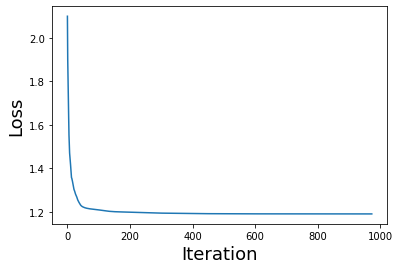

delta_psi shift & normalization by mean: 0.0024083041995591266 0.01075831186495752


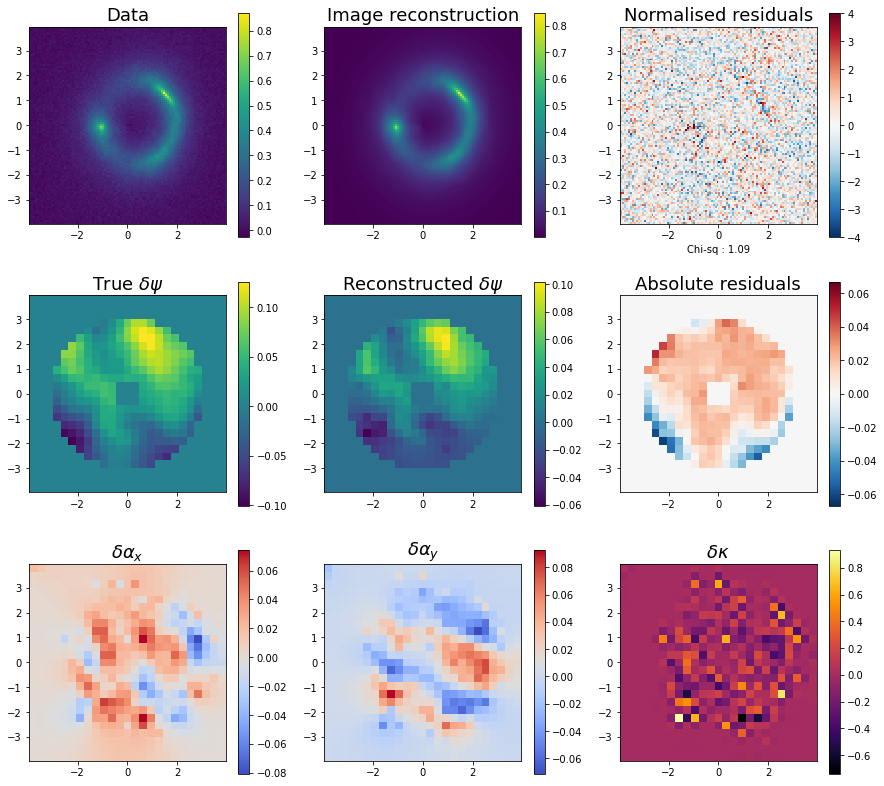

In [28]:
kwargs_final_wt = deepcopy(parameters.ML_values(as_kwargs=True))
plot_pixelated_potential_result(optimizer_wt, kwargs_final_wt,
                                shift_potential='mean', with_mask=True)